# Pré-processamento dos Dados

In [1]:
import importlib
import subprocess
import sys

def install_and_import(package):
    try:
        importlib.import_module(package)
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])
    finally:
        globals()[package] = importlib.import_module(package)

# Lista dos pacotes necessários (nome do pacote no PyPI)
required_packages = {
    "pandas": "pandas",
    "statsmodels": "statsmodels"
}

for module_name, package_name in required_packages.items():
    install_and_import(package_name)

import os
import argparse
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose

def load_data(input_dir):
    """Carrega arquivos CSV brutos"""
    ndvi = pd.read_csv(os.path.join(input_dir, 'ndvi_timeseries.csv'), parse_dates=['date'])
    flags = pd.read_csv(os.path.join(input_dir,'quality_flags.csv'), parse_dates=['date'])
    prod = pd.read_csv(os.path.join(input_dir,'productivity_history.csv'), parse_dates=['date'])
    return ndvi, flags, prod


def clean_ndvi(ndvi, flags, quality_threshold=0.8):
    """
    Filtra por qualidade e interpola valores faltantes.
    Assume que flags contém coluna 'quality' de 0 a 1.
    """
    # Merge NDVI e qualidade
    df = ndvi.merge(flags, on=['date', 'pixel_id'], how='left')
    # Filtrar apenas registros com qualidade >= threshold
    df = df[df['quality'] >= quality_threshold]
    # Média espacial (todos pixels) por data
    daily = df.groupby('date')['ndvi'].mean().reset_index()
    # Preencher datas faltantes
    daily = daily.set_index('date').asfreq('D')
    # Interpolação linear
    daily['ndvi'] = daily['ndvi'].interpolate(method='time')
    daily = daily.reset_index()
    return daily


def decompose_series(daily, model='additive', period=46):
    """Aplica decomposição sazonal e retorna DataFrame com trend, seasonal e residuo."""
    series = daily.set_index('date')['ndvi']
    decomp = seasonal_decompose(series, model=model, period=period)
    result = pd.DataFrame({
        'date': series.index,
        'observed': decomp.observed,
        'trend': decomp.trend,
        'seasonal': decomp.seasonal,
        'resid': decomp.resid
    }).reset_index(drop=True)
    return result


def save_outputs(daily, decomposition, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    daily.to_csv(os.path.join(output_dir, 'ndvi_clean.csv'), index=False)
    decomposition.to_csv(os.path.join(output_dir, 'decomposition.csv'), index=False)


def main():
    processed_dir = r'processed'
    raw_dir = r'raw'

    ndvi, flags, prod = load_data(raw_dir)
    daily = clean_ndvi(ndvi, flags)
    decomposition = decompose_series(daily)
    save_outputs(daily, decomposition, processed_dir)
    print('Pré-processamento concluído. Arquivos salvos em', processed_dir)

if __name__ == '__main__':
    main()


Pré-processamento concluído. Arquivos salvos em processed


# Construção do Modelo de Inteligência Artificial

In [2]:
import importlib
import subprocess
import sys

# Função para instalar e importar pacotes
# 'os' é módulo padrão e não precisa ser instalado
def install_and_import(package, import_name=None):
    if import_name is None:
        import_name = package
    try:
        importlib.import_module(import_name)
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])
    finally:
        globals()[import_name] = importlib.import_module(import_name)

# Lista dos pacotes necessários com seus nomes para importação
required_packages = {
    "pandas": "pandas",
    "numpy": "numpy",
    "scikit-learn": "sklearn"
}

for package, import_name in required_packages.items():
    install_and_import(package, import_name)

# Agora, pode importar os módulos/submódulos normalmente
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score


def load_processed_data(processed_dir, raw_dir):
    ndvi = pd.read_csv(os.path.join(processed_dir, 'ndvi_clean.csv'), parse_dates=['date'])
    decomp = pd.read_csv(os.path.join(processed_dir, 'decomposition.csv'), parse_dates=['date'])
    prod = pd.read_csv(os.path.join(raw_dir, 'productivity_history.csv'), parse_dates=['date'])
    return ndvi, decomp, prod

def build_and_evaluate_model(ndvi, decomp, prod):
    # Merge dos DataFrames
    df = ndvi.merge(decomp, on='date').merge(prod, on='date')

    features = ['ndvi', 'trend', 'seasonal', 'resid']
    target = 'productivity'

    n_amostras = len(df)
    print(f'Total de amostras: {n_amostras}')

    if n_amostras < 4:
        print("ERRO: O dataset é muito pequeno para treino, teste e validação cruzada. Adicione mais dados.")
        return

    # Separar treino e teste
    test_size = max(0.5, 2 / n_amostras) if n_amostras > 2 else 0.5
    X = df[features]
    y = df[target]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, shuffle=False
    )

    print(f"Amostras treino: {len(X_train)} | Amostras teste: {len(X_test)}")

    # Treinar modelo
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Prever e avaliar
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print('RMSE:', rmse)
    if len(y_test) >= 2:
        print('R2:', r2_score(y_test, y_pred))
    else:
        print('R2: Não definido (menos de 2 amostras no teste)')

    # Ajuste de hiperparâmetros
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [5, 10, 20, None]
    }
    cv_splits = min(3, len(X_train))
    if cv_splits < 2:
        print("Não há amostras suficientes para validação cruzada (GridSearchCV). Adicione mais dados.")
    else:
        grid = GridSearchCV(
            RandomForestRegressor(random_state=42),
            param_grid,
            cv=cv_splits,
            scoring='neg_mean_squared_error'
        )
        grid.fit(X_train, y_train)
        print('Melhores parâmetros:', grid.best_params_)

        # Avaliar o melhor modelo
        best_model = grid.best_estimator_
        y_pred_best = best_model.predict(X_test)
        rmse_best = np.sqrt(mean_squared_error(y_test, y_pred_best))
        print('Melhor RMSE:', rmse_best)
        if len(y_test) >= 2:
            print('Melhor R2:', r2_score(y_test, y_pred_best))
        else:
            print('Melhor R2: Não definido (menos de 2 amostras no teste)')

if __name__ == '__main__':
    # Ajuste os diretórios conforme sua estrutura
    processed_dir = r'processed'
    raw_dir = r'raw'
    ndvi, decomp, prod = load_processed_data(processed_dir, raw_dir)
    build_and_evaluate_model(ndvi, decomp, prod)




Total de amostras: 46
Amostras treino: 23 | Amostras teste: 23
RMSE: 425.4194566678922
R2: 0.7194710116843265
Melhores parâmetros: {'max_depth': 10, 'n_estimators': 50}
Melhor RMSE: 422.3196017615109
Melhor R2: 0.7235443136608102


# Avaliação e Ajustes no Modelo de Inteligência Artificial

Total de amostras: 46
Amostras treino: 23 | Amostras teste: 23


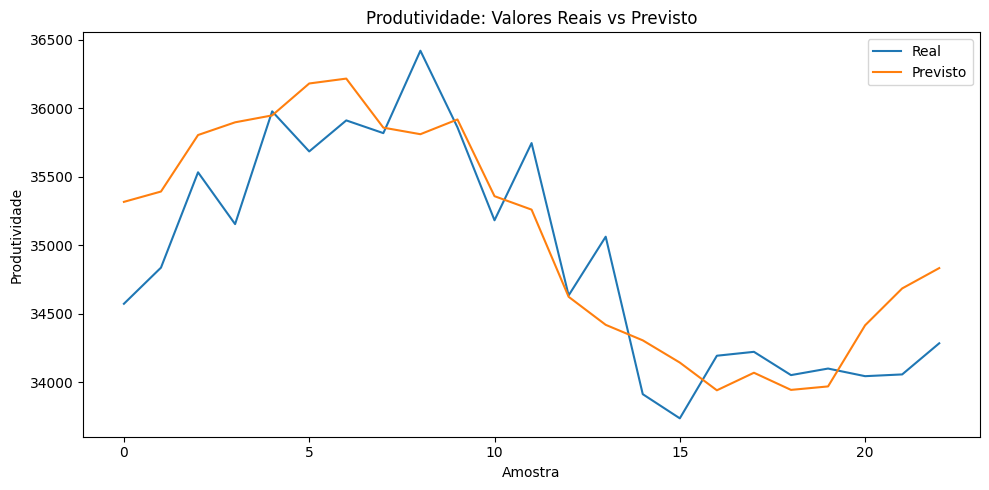

RMSE: 425.419
R2: 0.719
Melhores parâmetros: {'max_depth': 10, 'n_estimators': 50}


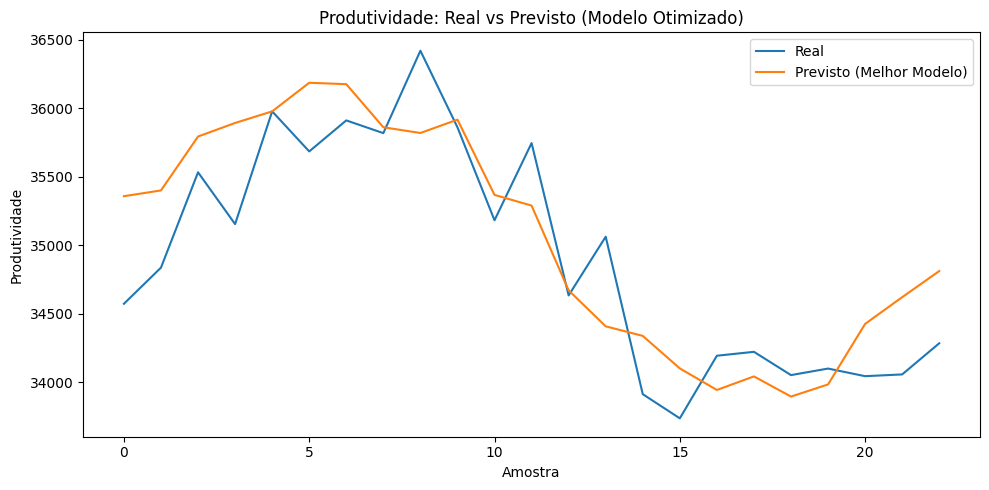

Melhor RMSE: 422.320
Melhor R2: 0.724


In [3]:
import importlib
import subprocess
import sys

# Função para instalar e importar pacotes
def install_and_import(package, import_name=None):
    if import_name is None:
        import_name = package
    try:
        importlib.import_module(import_name)
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])
    finally:
        globals()[import_name] = importlib.import_module(import_name)

# Lista dos pacotes necessários
required_packages = {
    "pandas": "pandas",
    "numpy": "numpy",
    "scikit-learn": "sklearn",
    "matplotlib": "matplotlib"
}

for package, import_name in required_packages.items():
    install_and_import(package, import_name)

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

def load_processed_data(processed_dir, raw_dir):
    ndvi = pd.read_csv(os.path.join(processed_dir, 'ndvi_clean.csv'), parse_dates=['date'])
    decomp = pd.read_csv(os.path.join(processed_dir, 'decomposition.csv'), parse_dates=['date'])
    prod = pd.read_csv(os.path.join(raw_dir, 'productivity_history.csv'), parse_dates=['date'])
    return ndvi, decomp, prod

def build_and_evaluate_model(ndvi, decomp, prod):
    # Merge dos DataFrames
    df = ndvi.merge(decomp, on='date').merge(prod, on='date')

    features = ['ndvi', 'trend', 'seasonal', 'resid']
    target = 'productivity'

    n_amostras = len(df)
    print(f'Total de amostras: {n_amostras}')

    if n_amostras < 4:
        print("ERRO: O dataset é muito pequeno para treino, teste e validação cruzada. Adicione mais dados.")
        return

    # Separar treino e teste
    test_size = max(0.5, 2 / n_amostras) if n_amostras > 2 else 0.5
    X = df[features]
    y = df[target]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, shuffle=False
    )

    print(f"Amostras treino: {len(X_train)} | Amostras teste: {len(X_test)}")

    # Treinar modelo padrão
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Prever e avaliar modelo padrão
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred) if len(y_test) >= 2 else None

    # Visualização do modelo padrão
    plt.figure(figsize=(10, 5))
    plt.plot(y_test.values, label='Real')
    plt.plot(y_pred, label='Previsto')
    plt.title('Produtividade: Valores Reais vs Previsto')
    plt.xlabel('Amostra')
    plt.ylabel('Produtividade')
    plt.legend()
    plt.tight_layout()
    plt.show()

    print(f'RMSE: {rmse:.3f}')
    if r2 is not None:
        print(f'R2: {r2:.3f}')
    else:
        print('R2: Não definido (menos de 2 amostras no teste)')

    # Ajuste de hiperparâmetros
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [5, 10, 20, None]
    }
    cv_splits = min(3, len(X_train))
    if cv_splits < 2:
        print("Não há amostras suficientes para validação cruzada (GridSearchCV). Adicione mais dados.")
        return
    else:
        grid = GridSearchCV(
            RandomForestRegressor(random_state=42),
            param_grid,
            cv=cv_splits,
            scoring='neg_mean_squared_error'
        )
        grid.fit(X_train, y_train)
        print('Melhores parâmetros:', grid.best_params_)

        # Avaliar o melhor modelo
        best_model = grid.best_estimator_
        y_pred_best = best_model.predict(X_test)
        rmse_best = np.sqrt(mean_squared_error(y_test, y_pred_best))
        r2_best = r2_score(y_test, y_pred_best) if len(y_test) >= 2 else None

        # Visualização do melhor modelo
        plt.figure(figsize=(10, 5))
        plt.plot(y_test.values, label='Real')
        plt.plot(y_pred_best, label='Previsto (Melhor Modelo)')
        plt.title('Produtividade: Real vs Previsto (Modelo Otimizado)')
        plt.xlabel('Amostra')
        plt.ylabel('Produtividade')
        plt.legend()
        plt.tight_layout()
        plt.show()

        print(f'Melhor RMSE: {rmse_best:.3f}')
        if r2_best is not None:
            print(f'Melhor R2: {r2_best:.3f}')
        else:
            print('Melhor R2: Não definido (menos de 2 amostras no teste)')

if __name__ == '__main__':
    # Ajuste os diretórios conforme sua estrutura
    processed_dir = r'processed'
    raw_dir = r'raw'
    ndvi, decomp, prod = load_processed_data(processed_dir, raw_dir)
    build_and_evaluate_model(ndvi, decomp, prod)
